In [107]:
import pandas as pd

df_blocks = pd.read_csv("Blocks.csv")
df_Block_Relation = pd.read_csv("Block_Relation.csv")
df_live = pd.read_csv('Live_Trains.csv')
df_stations = pd.read_csv('Stations.csv')
df_trains = pd.read_csv('Trains.csv')

In [108]:
df_ml = (
    df_live
    .merge(df_stations, left_on="halt_station", right_on="Station_name", how="left")
    .merge(df_blocks, on="block_no", how="left")
    .merge(df_trains[["Train no", "Train type"]], 
           left_on="Train_no", right_on="Train no", how="left")
)


In [109]:
drop_cols = ["Train_no", "Train name", "block_no", "halt_station", 
             "Station_name", "Train no"]
df_ml = df_ml.drop(columns=drop_cols, errors="ignore")


In [110]:
df_ml.head()



,Train_type,Train_name,IB(boolean),ETA_NS,ETA_DS,current_speed,DFNS,current delay,dwell time,time_delay,...,running_status(bool),PF_no,Total_platforms,free_platforms,starter_signal,home_signal,block_type,block_status,adv_starter_signal(bool),Train type
0,Superfast,Train_14939,False,2025-09-11 10:12:00,2025-09-11 12:09:00,48,13.69,0,34,41,...,True,4,6,3,False,False,Yard,Under_Maintenance,False,Superfast
1,Express,Train_20751,False,2025-09-11 10:01:00,2025-09-11 11:36:00,74,5.12,28,65,23,...,False,4,6,3,True,False,Yard,Under_Maintenance,False,Express
2,Passenger,Train_12745,False,2025-09-11 10:20:00,2025-09-11 12:45:00,62,6.14,43,169,29,...,False,2,6,2,False,False,Main,Occupied,True,Passenger
3,Vande Bharat,Train_14068,True,2025-09-11 10:00:00,2025-09-11 12:13:00,49,7.18,0,30,48,...,False,1,5,3,True,True,Main,Free,True,Vande Bharat
4,Passenger,Train_13680,False,2025-09-11 10:17:00,2025-09-11 12:25:00,56,11.92,69,153,26,...,False,4,12,10,False,False,Loop,Under_Maintenance,True,Passenger


In [111]:
print(df_ml.columns)

Index(['Train_type', 'Train_name', 'IB(boolean)', 'ETA_NS', 'ETA_DS',
       'current_speed', 'DFNS', 'current delay', 'dwell time', 'time_delay',
       'block_len', 'Approaching_block_no', 'advance_block_no',
       'running_status(bool)', 'PF_no', 'Total_platforms', 'free_platforms',
       'starter_signal', 'home_signal', 'block_type', 'block_status',
       'adv_starter_signal(bool)', 'Train type'],
      dtype='object')


In [112]:
df_ml.columns

Index(['Train_type', 'Train_name', 'IB(boolean)', 'ETA_NS', 'ETA_DS',
       'current_speed', 'DFNS', 'current delay', 'dwell time', 'time_delay',
       'block_len', 'Approaching_block_no', 'advance_block_no',
       'running_status(bool)', 'PF_no', 'Total_platforms', 'free_platforms',
       'starter_signal', 'home_signal', 'block_type', 'block_status',
       'adv_starter_signal(bool)', 'Train type'],
      dtype='object')

In [113]:
X = df_ml.drop(columns=['dwell time'])
y = df_ml['dwell time']

In [114]:
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object',]).columns.tolist()


In [115]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numeric_cols),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_cols)
    ],
    remainder='drop'
)

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor( random_state=1))
])

In [118]:
params = {
    "model__n_estimators": [ 100, 200],
    "model__max_depth": [5, None],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_leaf": [1, 2],
    "model__min_samples_split": [5, 10]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
grid_search.fit(X_train,y_train)

print("Best CV Score:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Best CV Score: -633.5751369166062
Best Params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}


Evaluation

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R2:", r2)


Test RMSE: 24.43763396875237
Test MAE: 18.532641407925915
Test R2: 0.563677921023507


In [120]:
# Feature Importance 
import pandas as pd

# Get feature names after preprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importances = best_model.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)
print(feat_imp.head(10))


                           feature  importance
11       cat__Train_type_Passenger    0.129687
1125     cat__Train type_Passenger    0.089877
14       cat__Train_type_Superfast    0.045622
1128     cat__Train type_Superfast    0.035391
15    cat__Train_type_Vande Bharat    0.035127
12        cat__Train_type_Rajdhani    0.022684
1129  cat__Train type_Vande Bharat    0.022681
0               num__current_speed    0.021504
5        num__Approaching_block_no    0.019996
1                        num__DFNS    0.019850


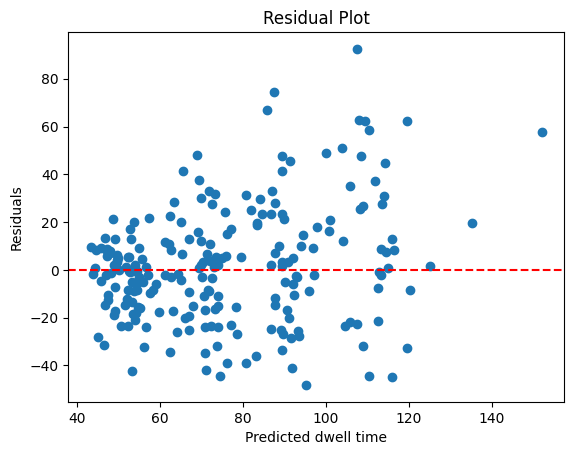

In [121]:
# Check Residuals
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted dwell time")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
